In [149]:
import math
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
%config InlineBackend.figure_format = 'retina'
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FuncFormatter, MaxNLocator

import matplotlib as mpl



In [150]:
def mean_pareto(a):
    return a/float(a-1)
mean_pareto(3)

1.5

TODO:
1. so I have daily returns of the last 10 years. I take log of these returns. I calculate the mean & standard deviation of these returns
2. Then I generate random numbers from a normal distribution with same mean and standard deviation as above
3. I try to compare the two distributions (1& 2) above to see if these fit well or are similar. This would tell me how well the lognormal distribution would have predicted the returns?

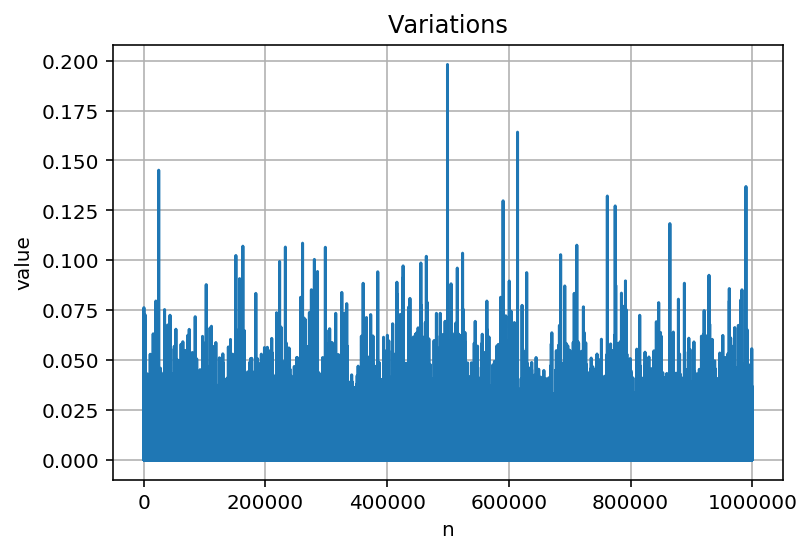

In [151]:
pareto_list = list(np.random.pareto(4.5,1000000)/100)
plt.plot(range(len(pareto_list)), pareto_list)
plt.xlabel("n")
plt.ylabel("value")
plt.title("Variations")
plt.grid()
mpl.rcParams['figure.figsize'] = (10,3)

In [152]:
def generate_stock_time_series_based_on_pareto_dist(alpha=4.0, n=10000, h=0.5):
    s0 = 10
    s = s0
    prices = [s]
    changes_list = [0]
    last_signal = 1
    signal = 1
    for i in range(n):
        pareto_change = np.random.pareto(alpha,1)[0]/100
        if np.random.binomial(1, h) == 0:
            signal = -1*last_signal
        
        last_signal = signal
        s = s*(1+signal*pareto_change)
        prices.append(s)
        changes_list.append(signal*pareto_change)

    
#     plt.rcParams.update({'font.size': 22})
#     fig, ax = plt.subplots(figsize=(30, 16))
#     p1 = ax.plot(range(len(changes_list)), changes_list, color="orchid", label='Change %')

#     ax.set_xlabel('n')
#     ax.grid()
#     ax.set_ylabel('changes in %')

    
#     ax2 = ax.twinx()
#     p2 = ax2.plot(range(len(changes_list)), values_list, color="steelblue", label='Price')
#     ax2.set_ylabel('price')

#     lns = p1+p2
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs, loc=1)

    plt.show()

    return prices
    


In [153]:
def plot_all(prices, dates, stock_name=''):
    mpl.rcParams['figure.figsize'] = (15,10)
    plt.rcParams.update({'font.size': 10})
    def plot_data(ax, y_values, x_label_ticks, xlabel='Time', ylabel='Price', title='Price', log_scale=None, y_values_2=None):
        if not log_scale:
            ax.plot(range(len(y_values)), y_values)
            if y_values_2:
                ax.plot(range(len(y_values_2)), y_values_2)
        else:
            ax.semilogy(range(len(y_values)), y_values)
            if y_values_2:
                ax.semilogy(range(len(y_values_2)), y_values_2)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid()

        nticks = 10
        ax.xaxis.set_major_locator(MaxNLocator(nticks))
        ax.set_xticklabels(x_label_ticks[::int(len(x_label_ticks)/nticks)])


    def get_daily_changes(values, dates,log_scale=False):
        daily_changes = [0]
        daily_changes_dates = [dates[0]]

        for i in range(1,len(values)):
            previous_value = values[i-1]
            current_value = values[i]
            if math.isnan(previous_value) or math.isnan(current_value):
                continue

            if log_scale:
                change = current_value/previous_value-1
                change = math.log(change+1)
            else:
                change = current_value - previous_value

            daily_changes.append(change)
            daily_changes_dates.append(dates[i])

        return daily_changes, daily_changes_dates

    fig, (ax1, ax2) = plt.subplots(2)
    plot_data(ax1, prices, dates, xlabel='Time', ylabel='Price', title=stock_name+' Price', log_scale=None)
    plot_data(ax2, prices, dates, xlabel='Time', ylabel='Price', title=stock_name+' Price (Log)', log_scale=True)

    fig, (ax1, ax2) = plt.subplots(2)
    daily_changes, daily_changes_dates = get_daily_changes(prices, dates, log_scale=False)
    plot_data(ax1, daily_changes, daily_changes_dates, xlabel='Time', ylabel='Daily Changes', title=stock_name+' Changes Absolute', log_scale=None)

    daily_changes_log, daily_changes_dates_log = get_daily_changes(prices, dates, log_scale=True)
    plot_data(ax2, daily_changes_log, daily_changes_dates_log, xlabel='Time', ylabel='Daily Changes Log', title=stock_name+' Changes Log', log_scale=None)

    fig, (ax1, ax2) = plt.subplots(2)
    mean_changes = np.mean(daily_changes_log)
    std_changes = np.std(daily_changes_log)
    std_dev_changes = [abs(v-mean_changes)/std_changes for v in daily_changes_log]
    plot_data(ax1, std_dev_changes, daily_changes_dates_log, xlabel='Time', ylabel='Daily Changes in Std', title=stock_name+' Changes in Std', log_scale=None)
    

In [154]:
from datetime import datetime
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def get_hurst(ts):

    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    # Here it calculates the variances, but why it uses 
    # standard deviation and then make a root of it?
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0



In [155]:
prices = generate_stock_time_series_based_on_pareto_dist(5.0, 10000, h=0.9)
get_hurst(prices)

0.6168029388353469

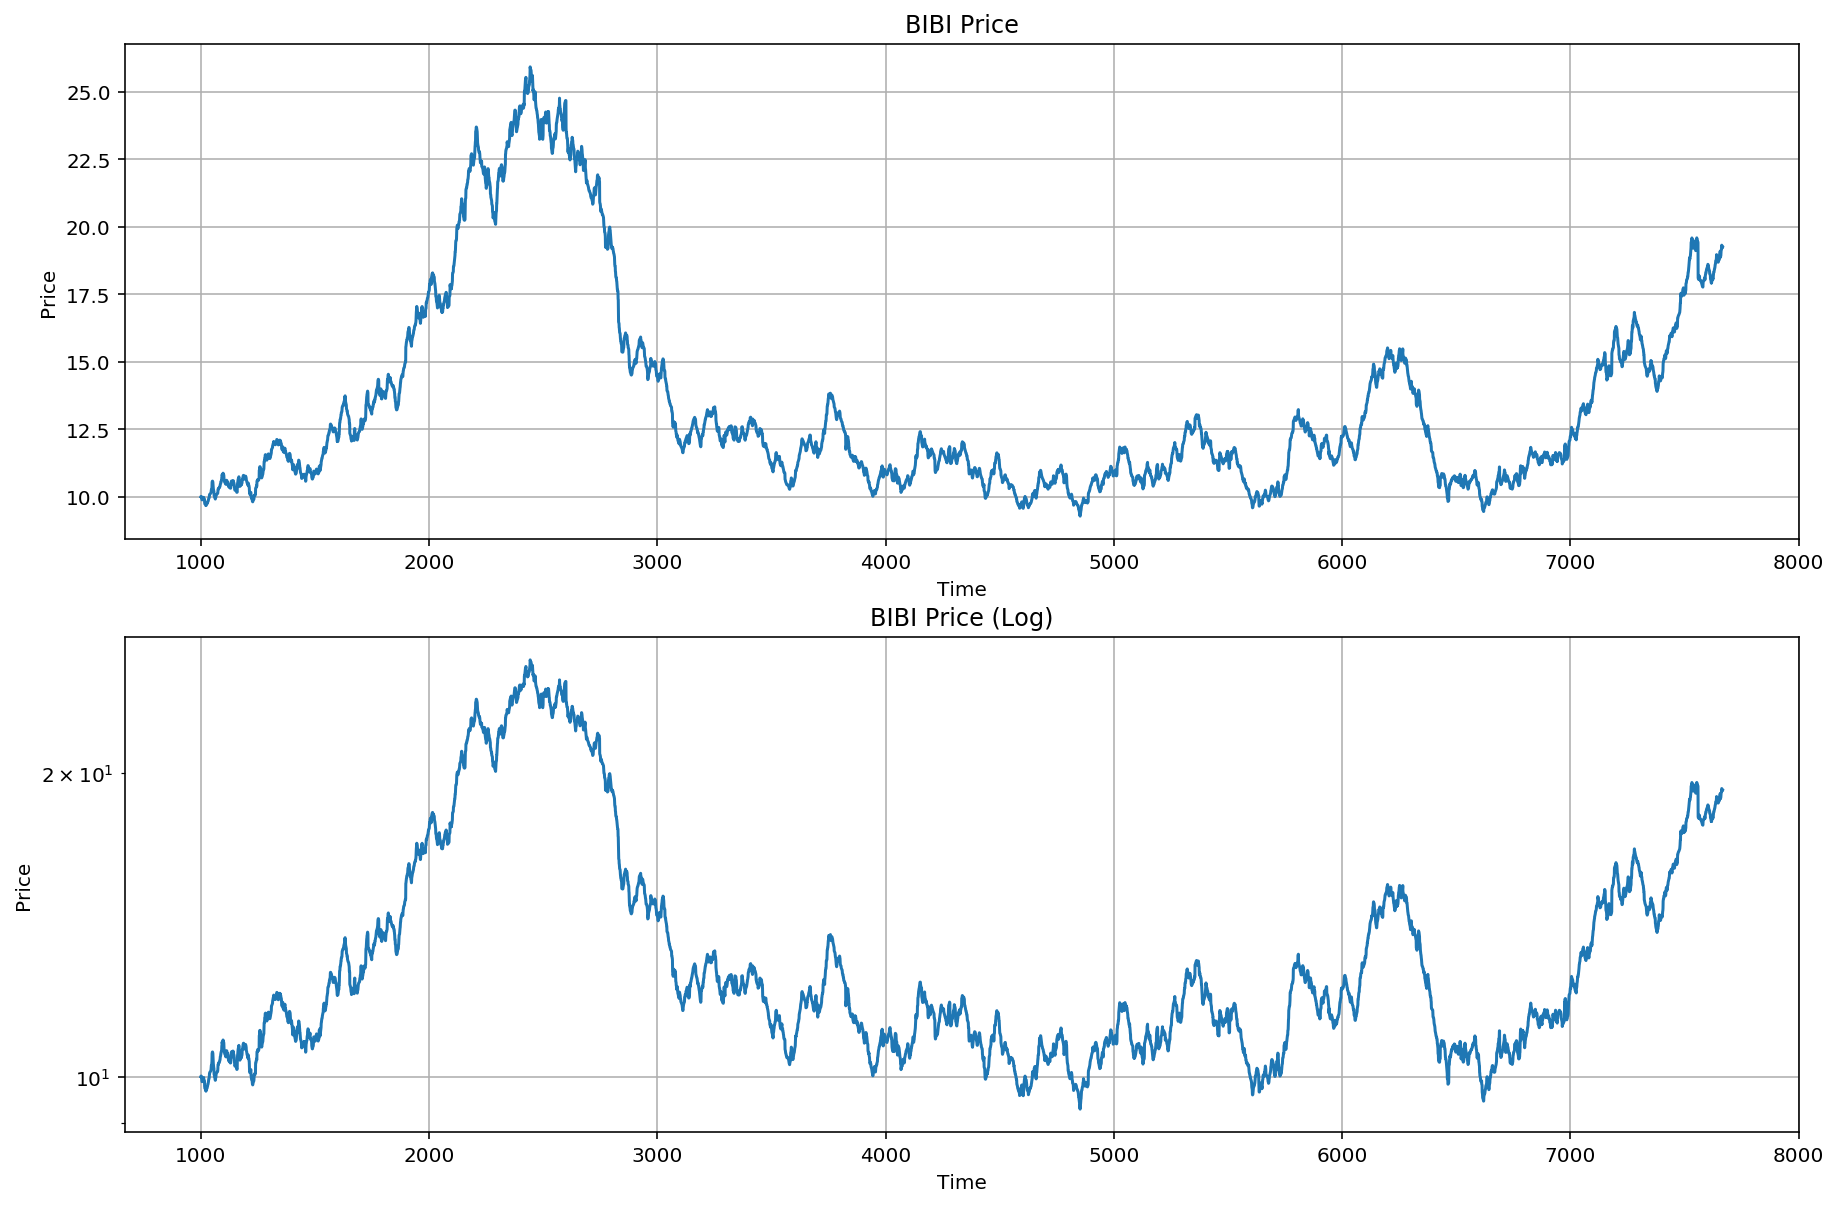

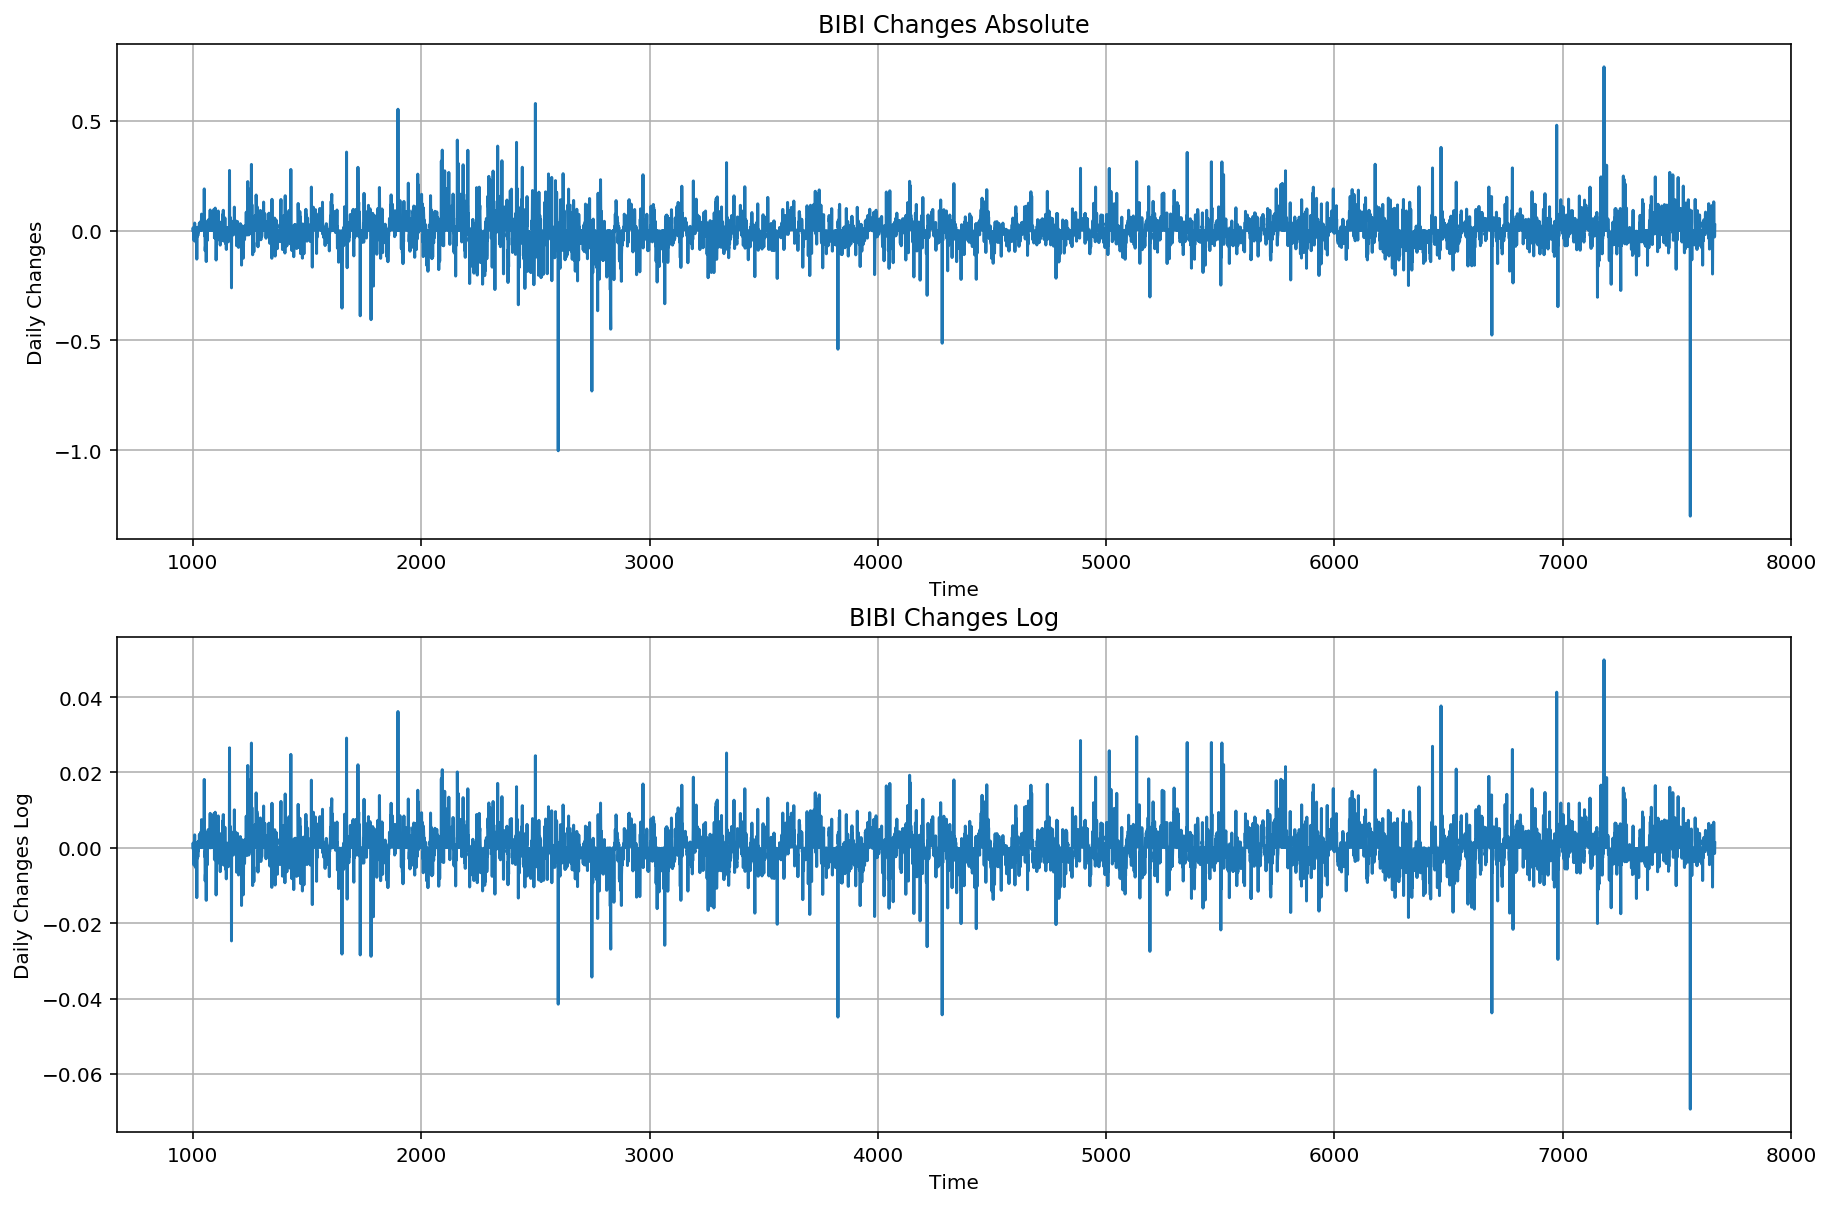

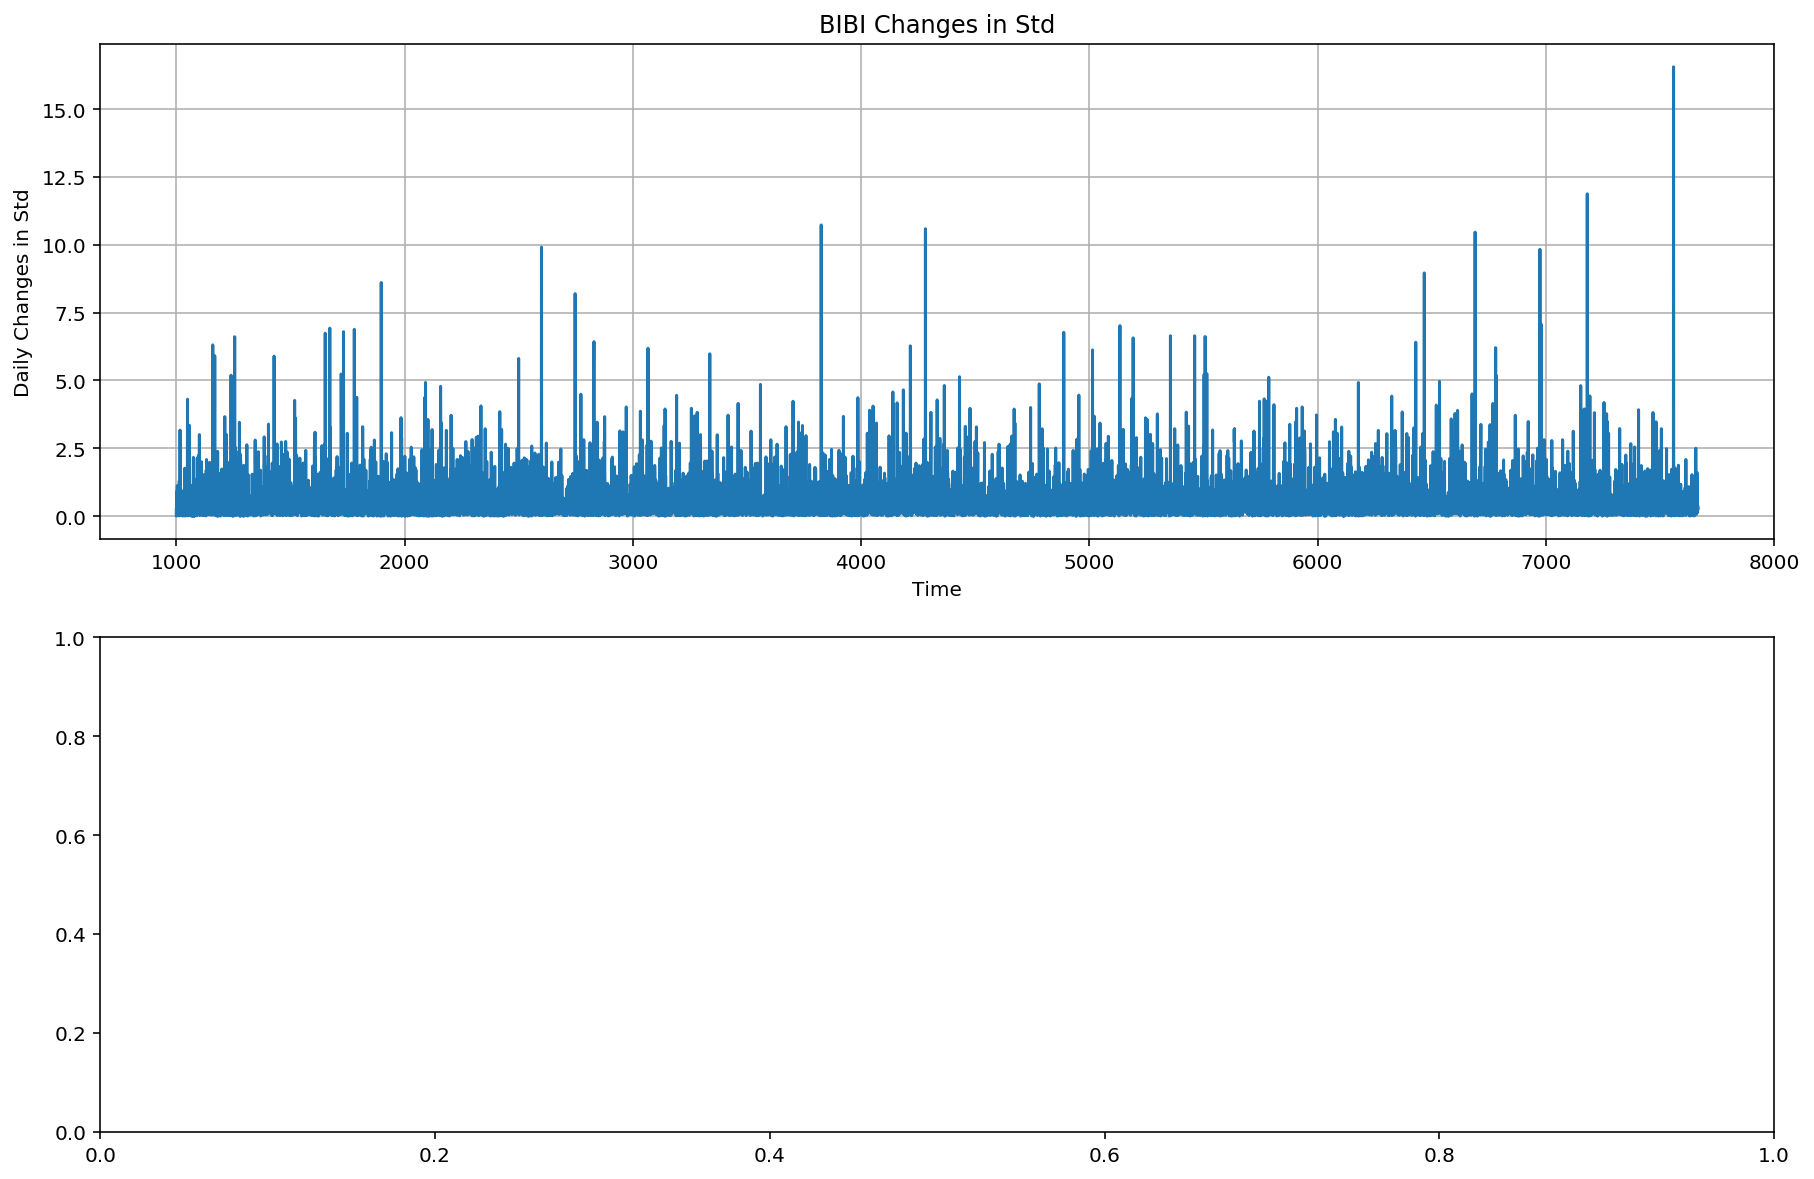

In [156]:
plot_all(prices, range(len(prices)), stock_name='BIBI')

# Real Stocks

In [157]:
stock_data = pd.read_csv("dow.csv") 
stock_data.keys()
stock_prices = list(stock_data['Close'])
stock_dates = list(stock_data['Date'])

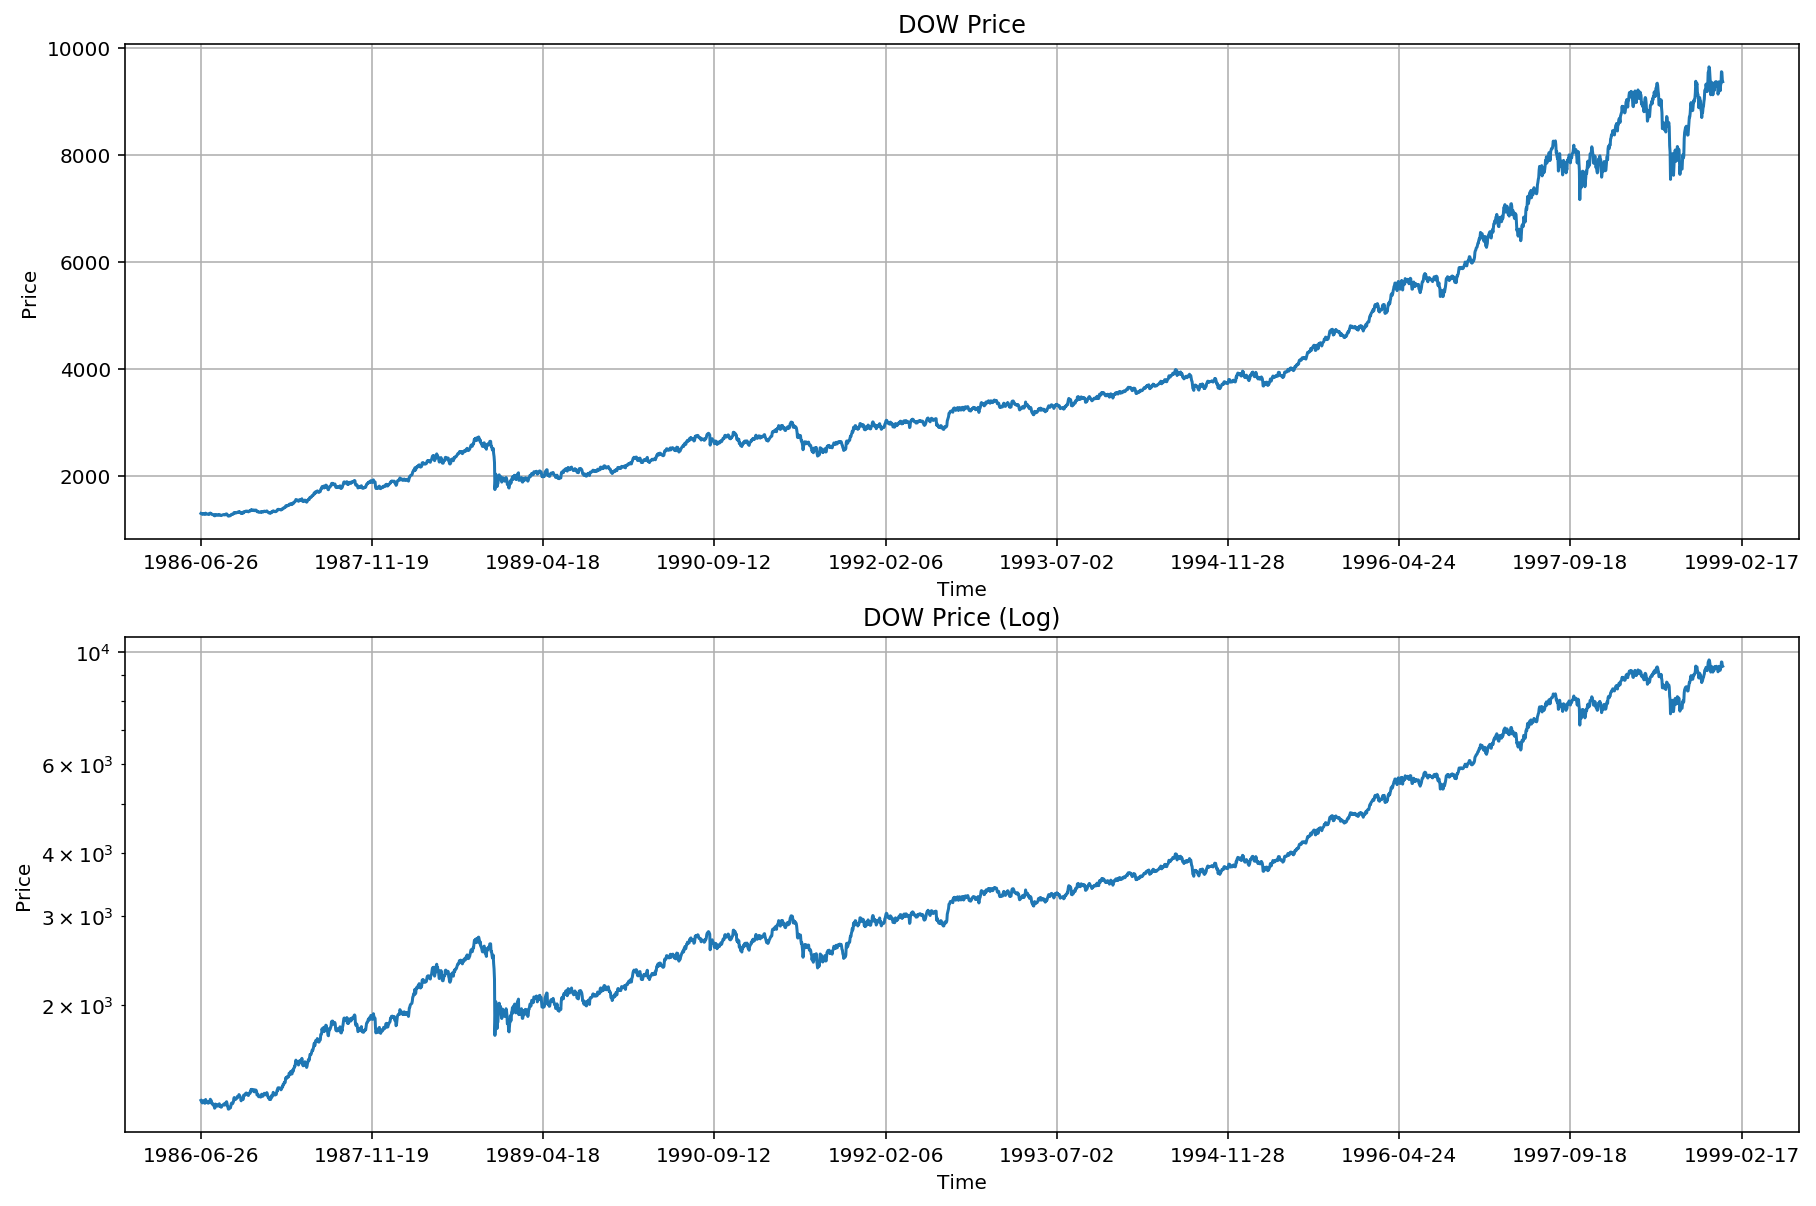

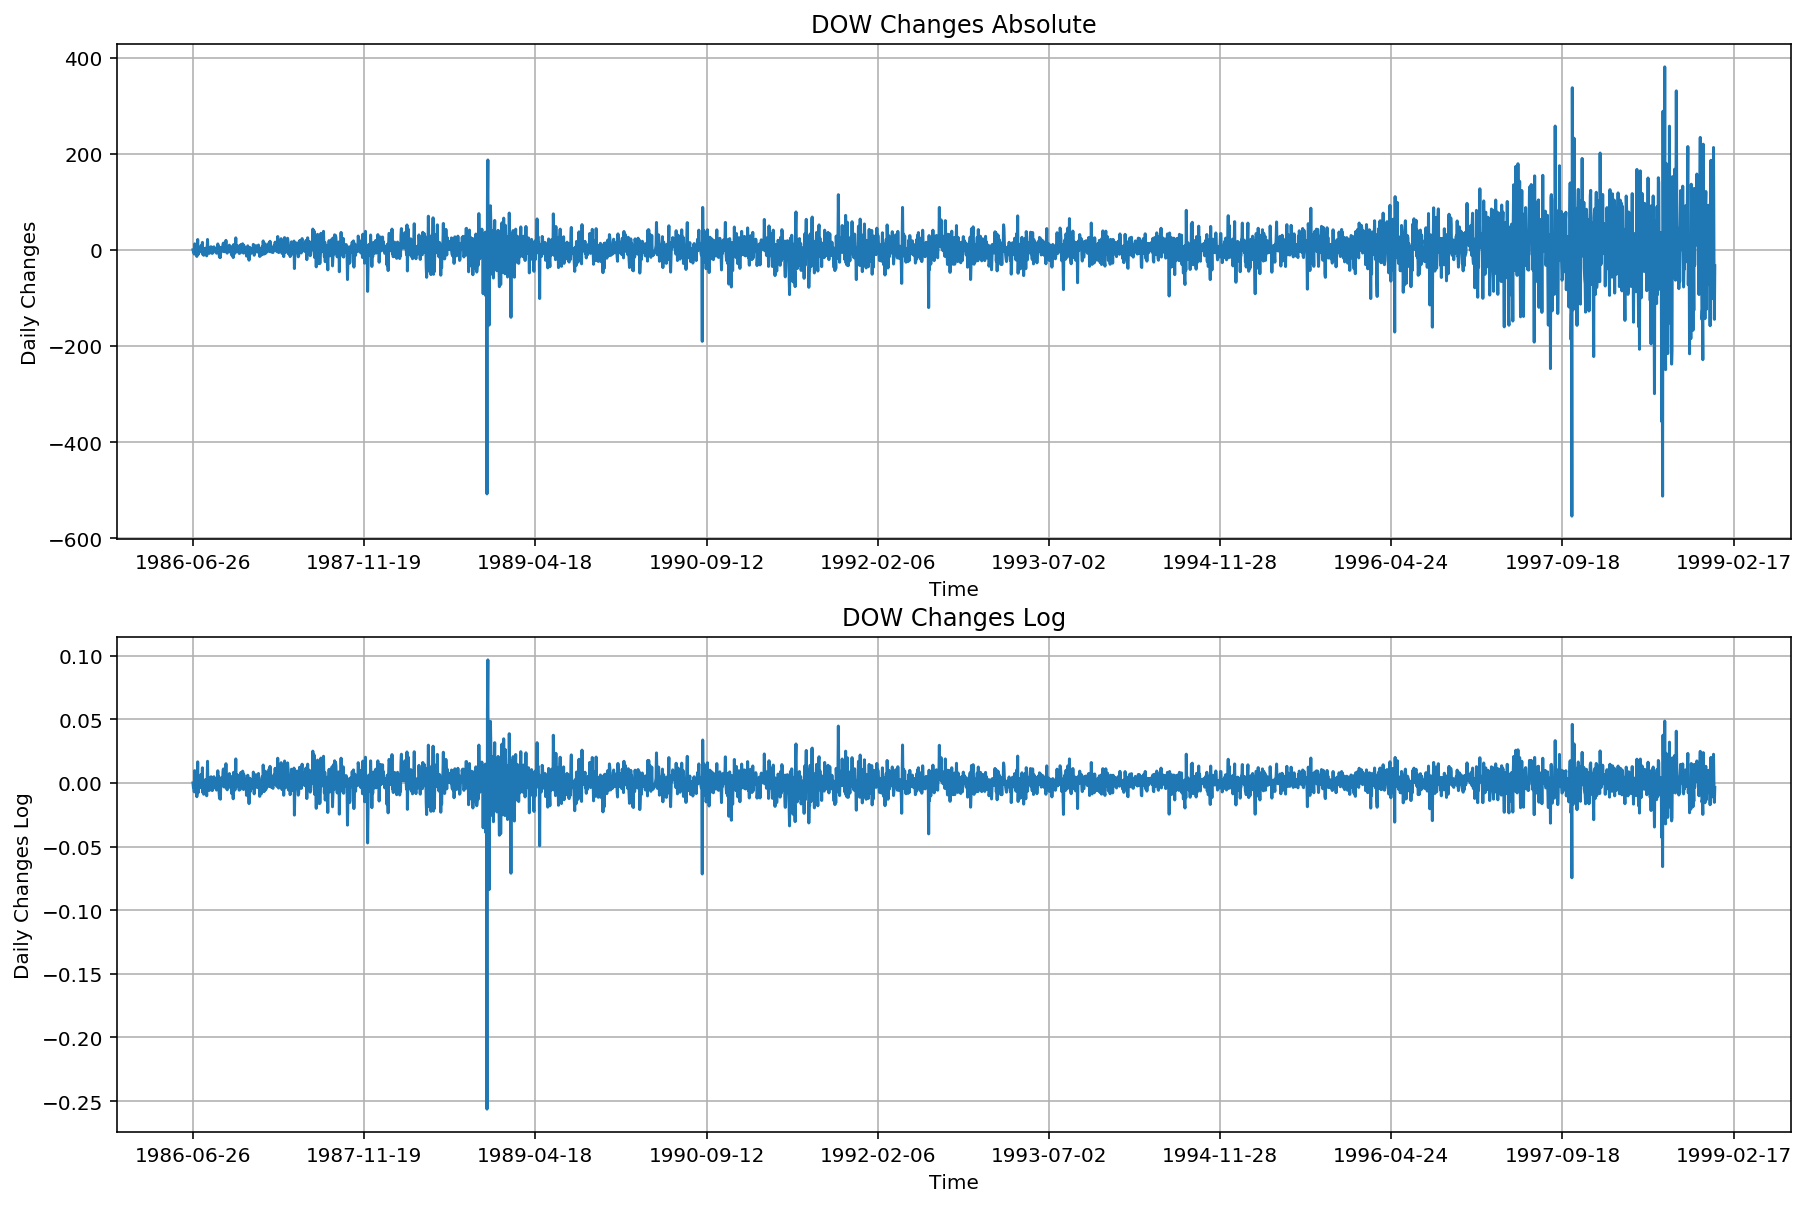

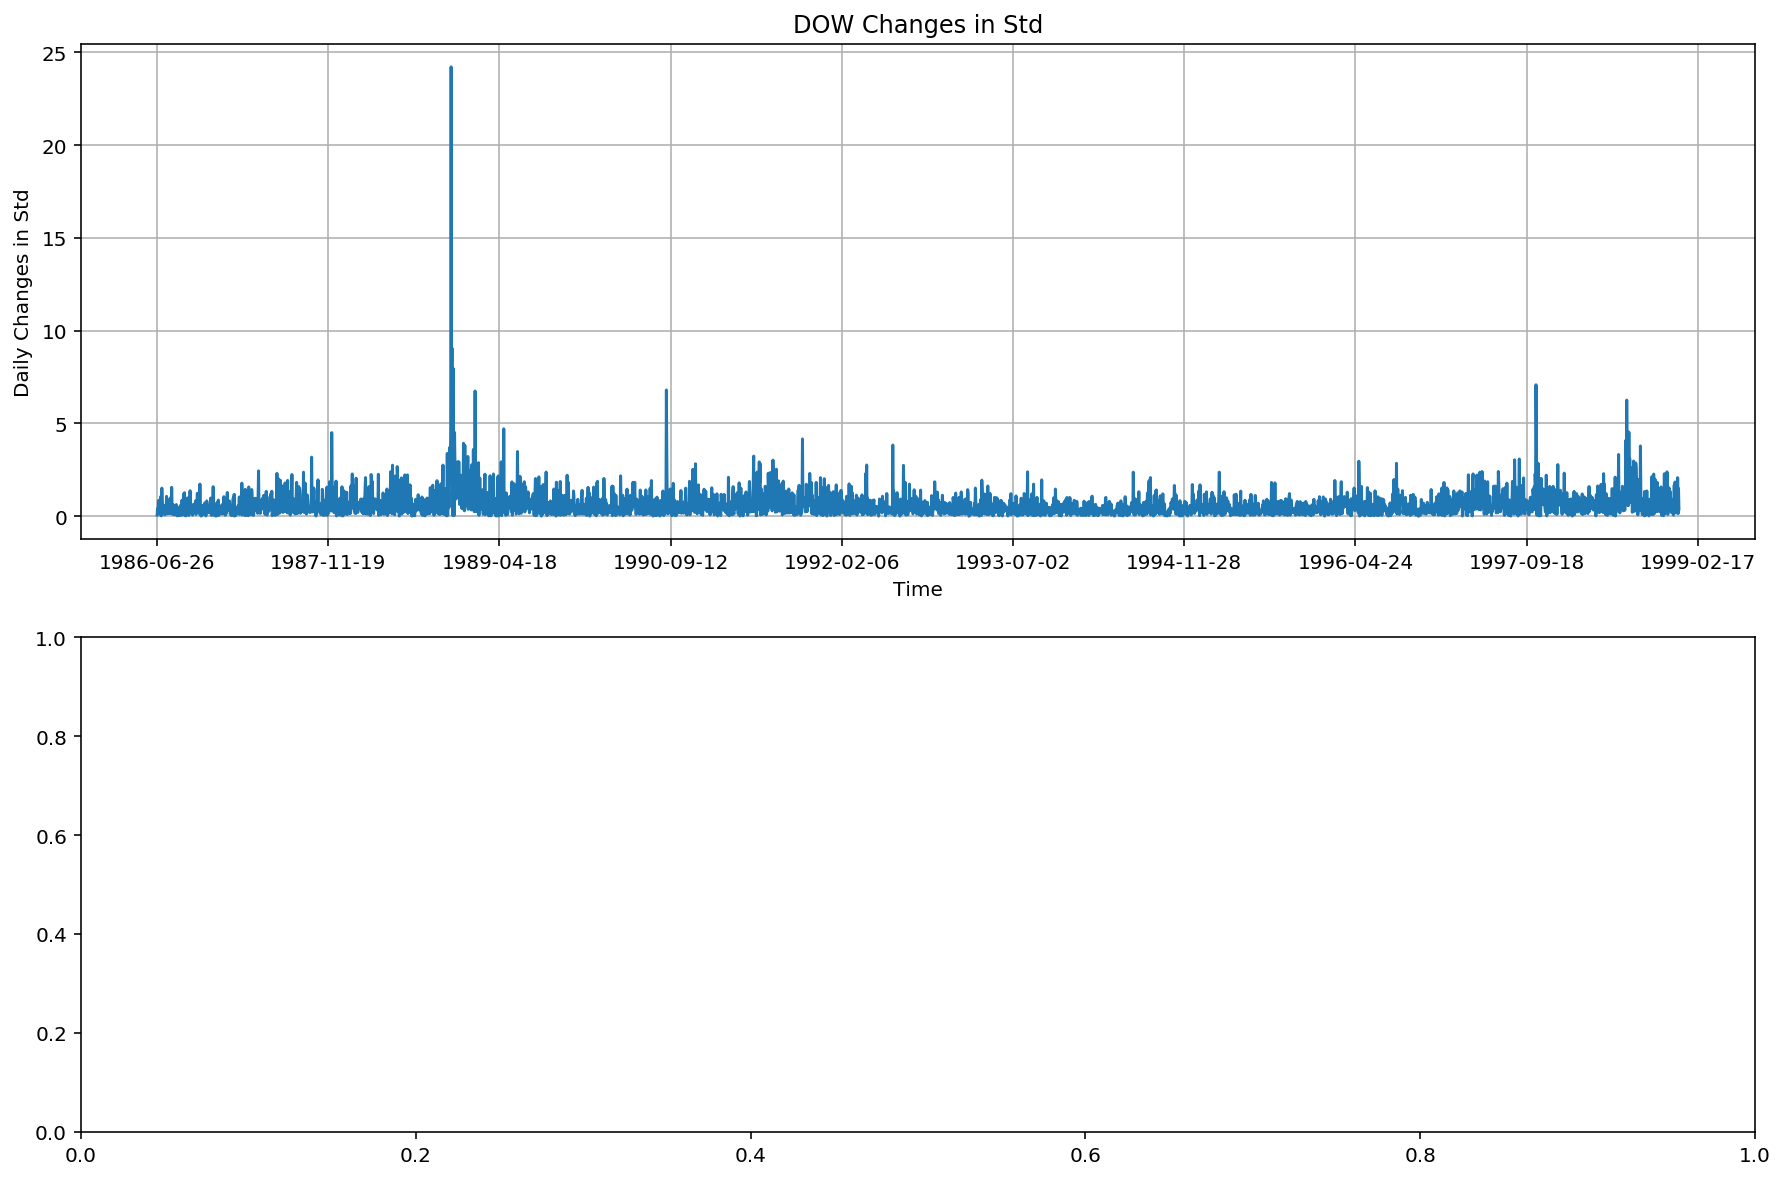

In [158]:
mpl.rcParams['figure.figsize'] = (15,10)
plot_all(stock_prices, stock_dates, stock_name='DOW')

# Fractal Stock Movements

In [159]:
def shuffle_according_to_hurst(hurst, diffs, up_trend=True):
    new_diffs = []
    while diffs:
        should_follow_trend = True if np.random.binomial(1, hurst) == 1 else False
        shuffle(diffs)
        if (up_trend and should_follow_trend) or (not up_trend and not should_follow_trend):
            if diffs[0][1] > 0:
                new_diffs.append(diffs[0])
                diffs.pop(0)
                
        elif (up_trend and not should_follow_trend) or (not up_trend and should_follow_trend):
             if diffs[0][1] < 0:
                new_diffs.append(diffs[0])
                diffs.pop(0)
    
    return new_diffs

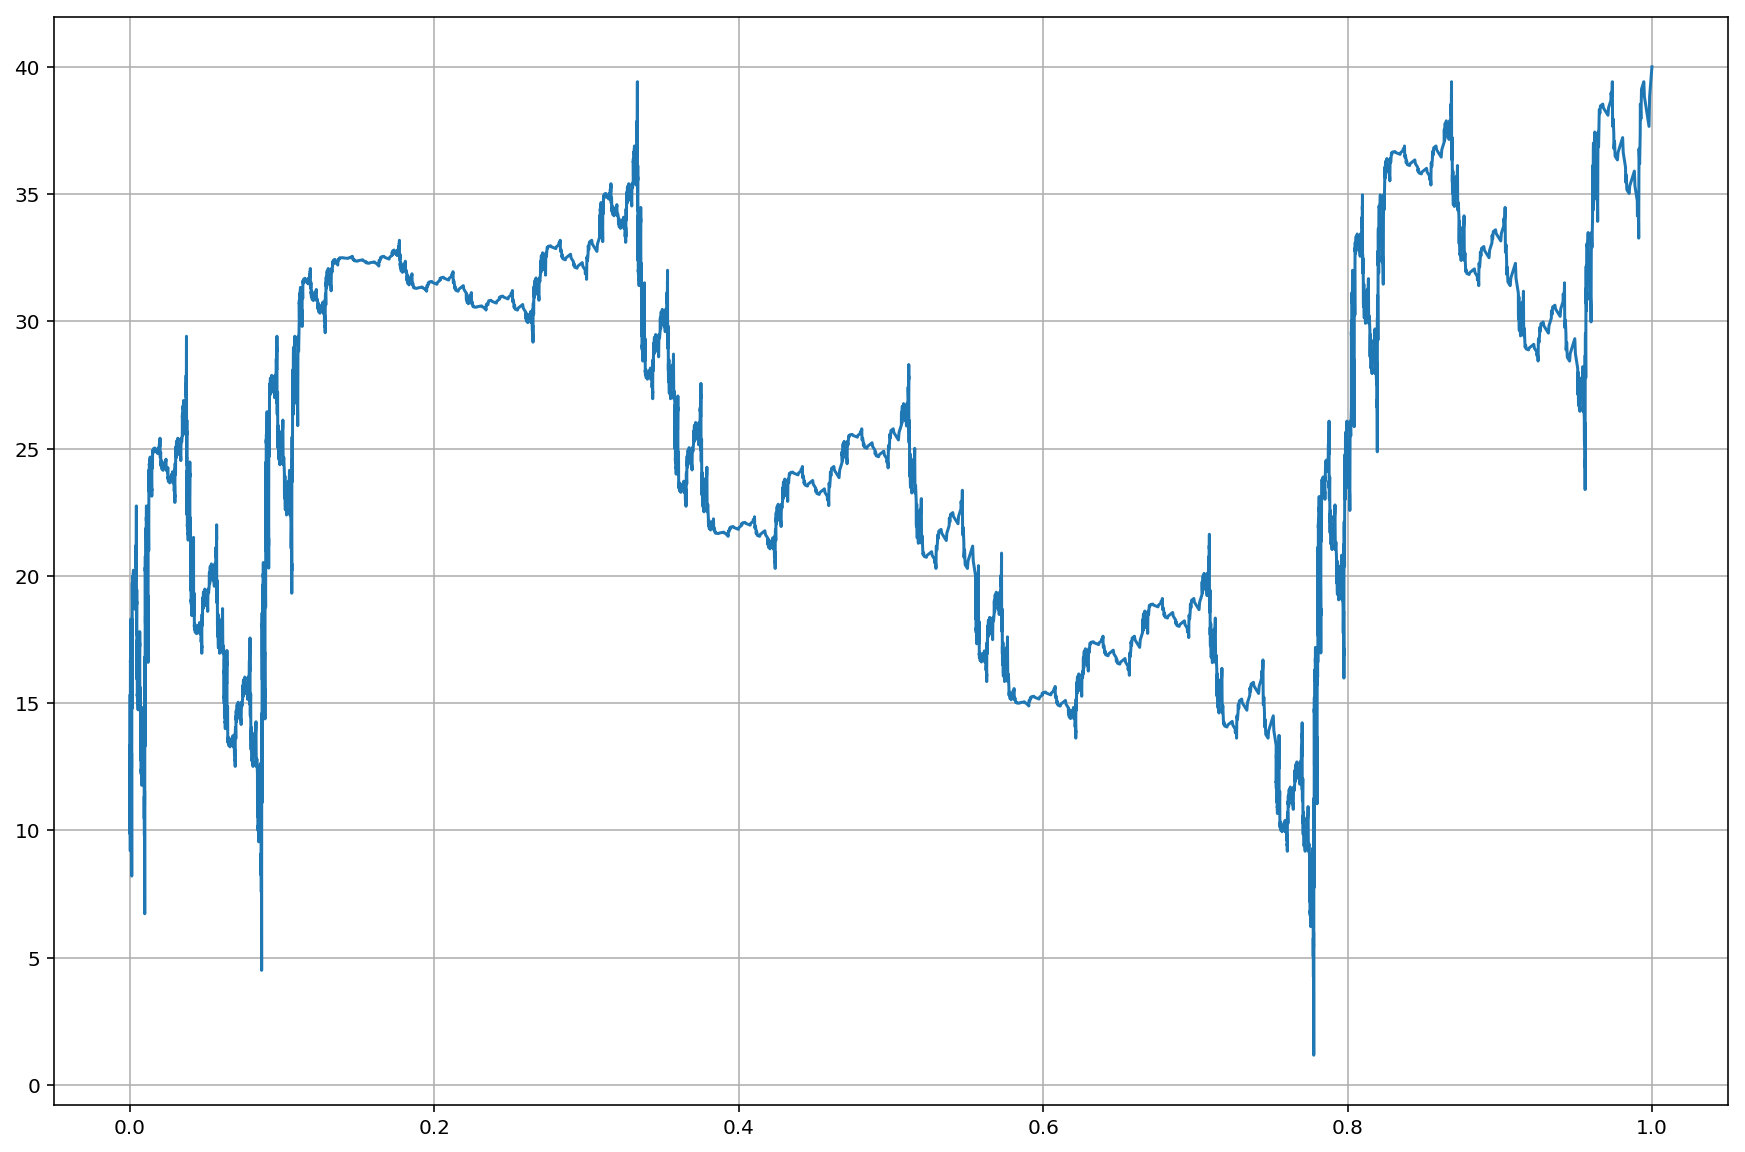

In [160]:
from __future__ import division
from random import shuffle
i = 0
def make_graph(depth, graph, start, end, turns, hurst):
    # add points to graph
    graph.add(start)
    graph.add(end)

    if depth > 0:   
        # unpack input values
        fromtime, fromvalue = start
        totime, tovalue = end

        # calcualte differences between points
        diffs = []
        last_time, last_val = fromtime, fromvalue
        for t, v in turns:
            new_time = fromtime + (totime - fromtime) * t
            new_val = fromvalue + (tovalue - fromvalue) * v
            diffs.append((new_time - last_time, new_val - last_val))
            last_time, last_val = new_time, new_val

# add 'brownian motion' by reordering the segments        
#         shuffle(diffs)
        
        index = list(sorted(graph, key=lambda x: x[0])).index((fromtime, fromvalue))
        up_trend = True
        if index >= 1:
            previous_val = list(sorted(graph, key=lambda x: x[0]))[index-1][1]
            up_trend = fromvalue > previous_val
            
        diffs = shuffle_according_to_hurst(hurst, diffs, up_trend=up_trend)
        

        # calculate actual intermediate points and recurse
        last = start
        for segment in diffs:
            p = last[0] + segment[0], last[1] + segment[1]
            make_graph(depth - 1, graph, last, p, turns, hurst)
            last = p
        make_graph(depth - 1, graph, last, end, turns, hurst)

from matplotlib import pyplot
depth = 8
graph = set()
make_graph(depth, graph, (0, 10), (1, 40), [(1/9, 2/3), (5/9, 1/3)], hurst=0.99)
pyplot.plot(*zip(*sorted(graph)))
pyplot.grid()
pyplot.show()

In [161]:
fractal_prices = [v[1] for v in graph]
get_hurst(fractal_prices)

0.0001839903397599581

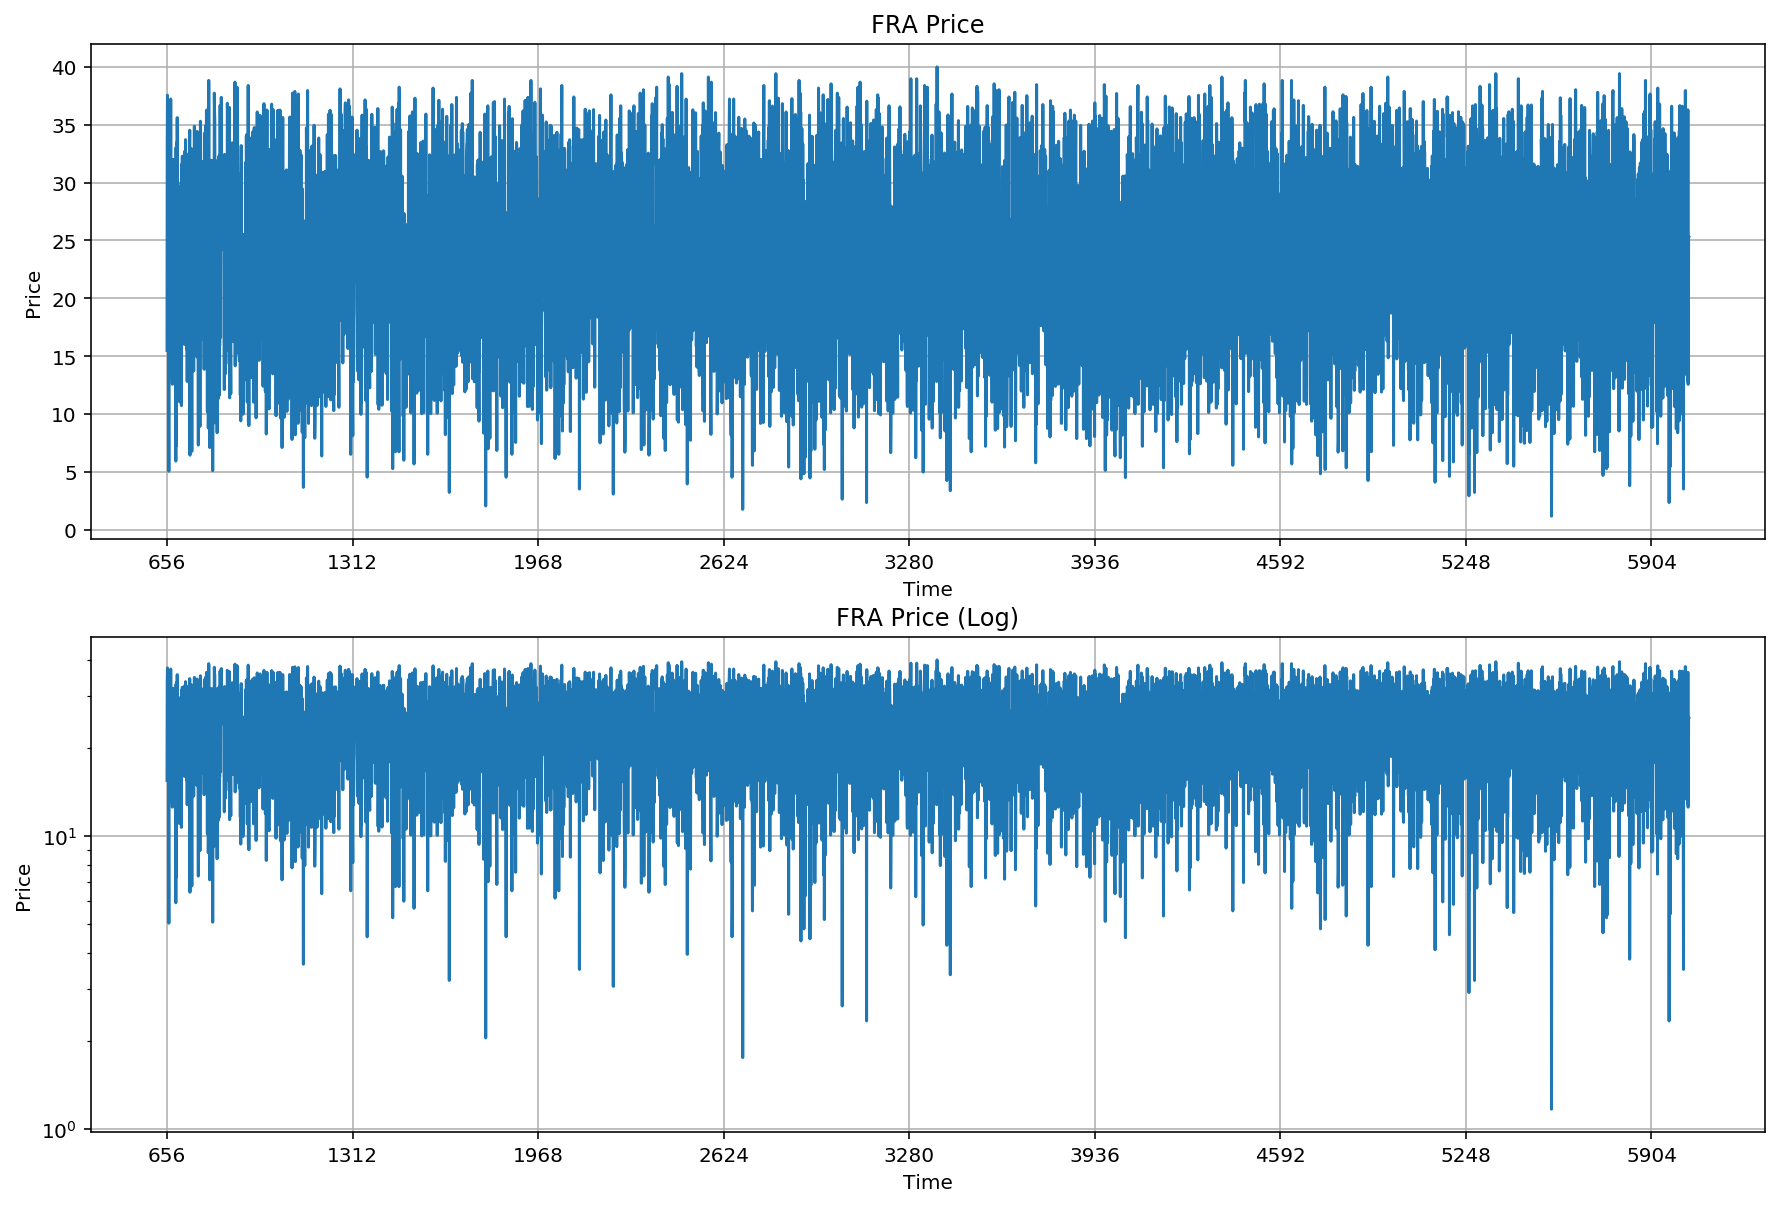

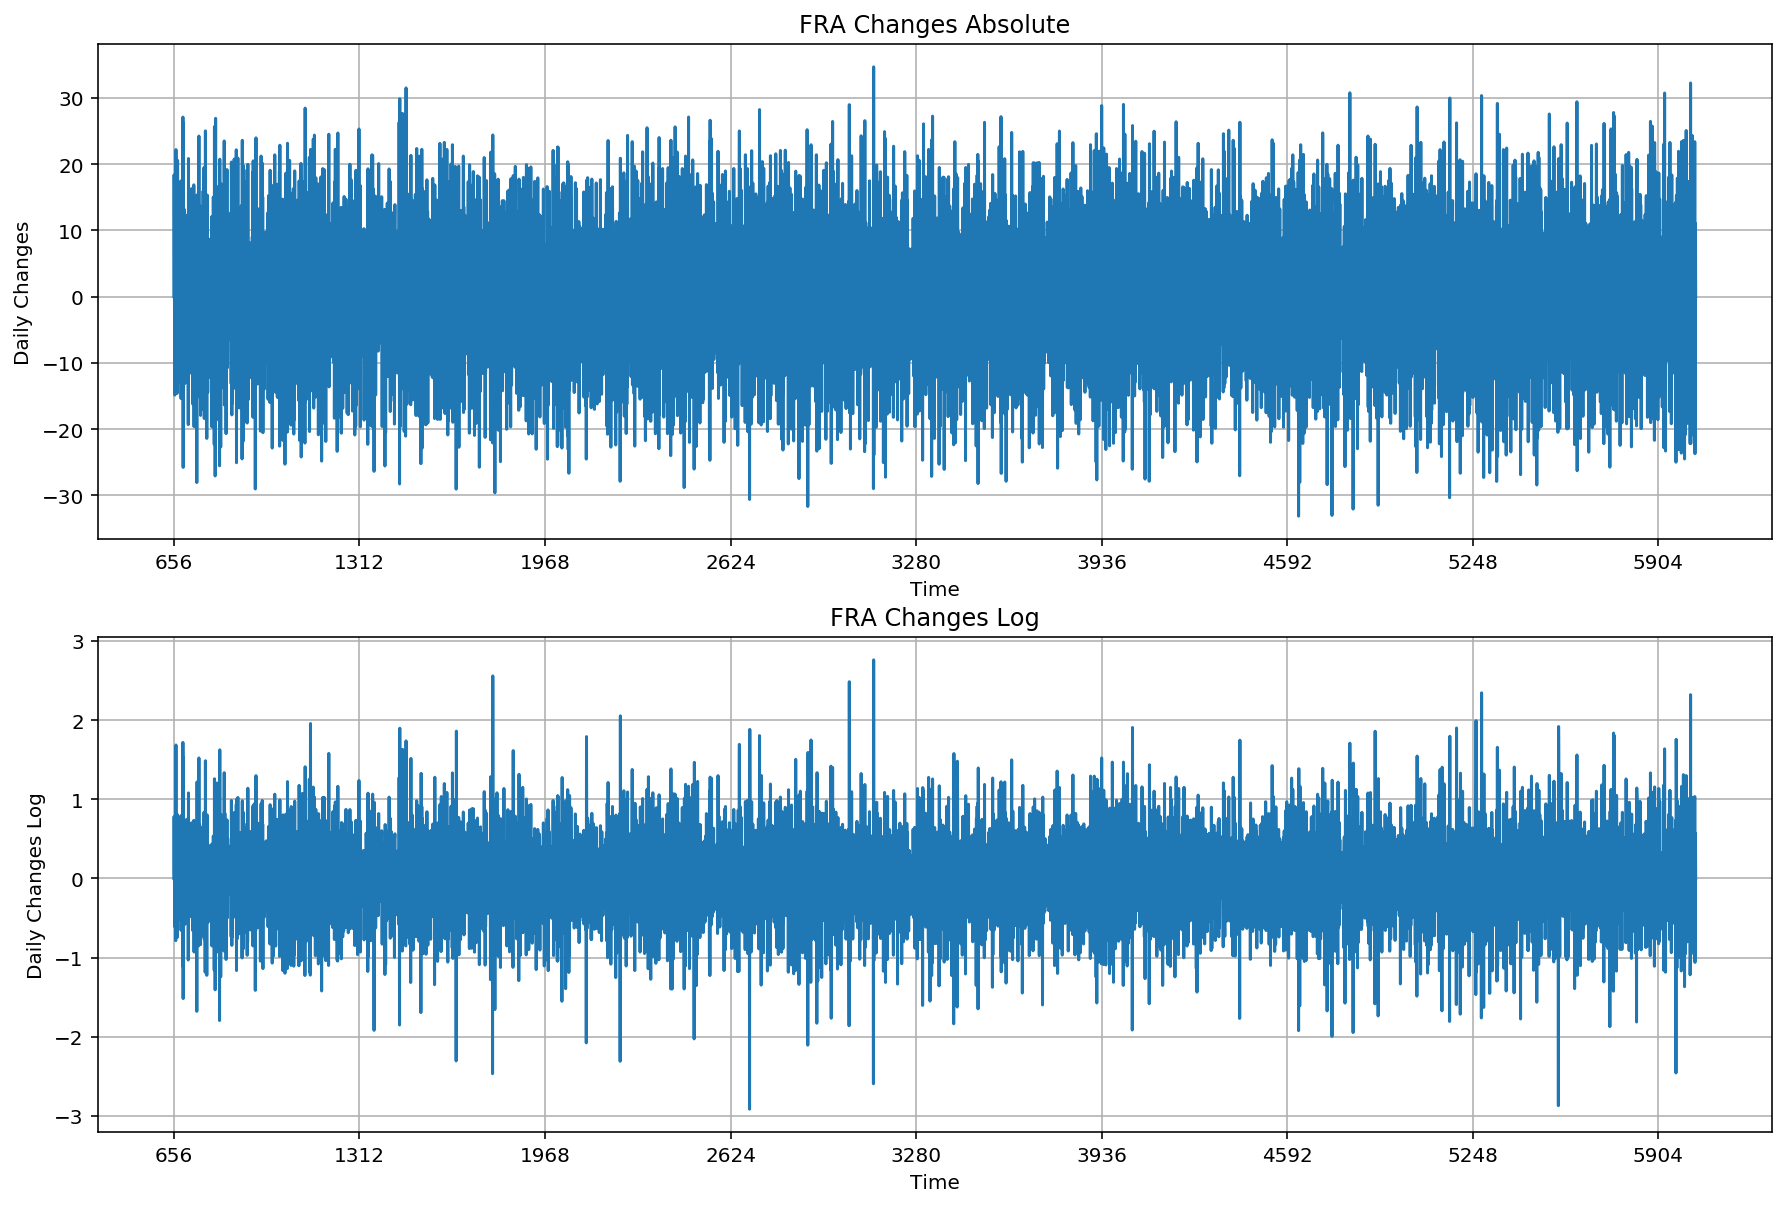

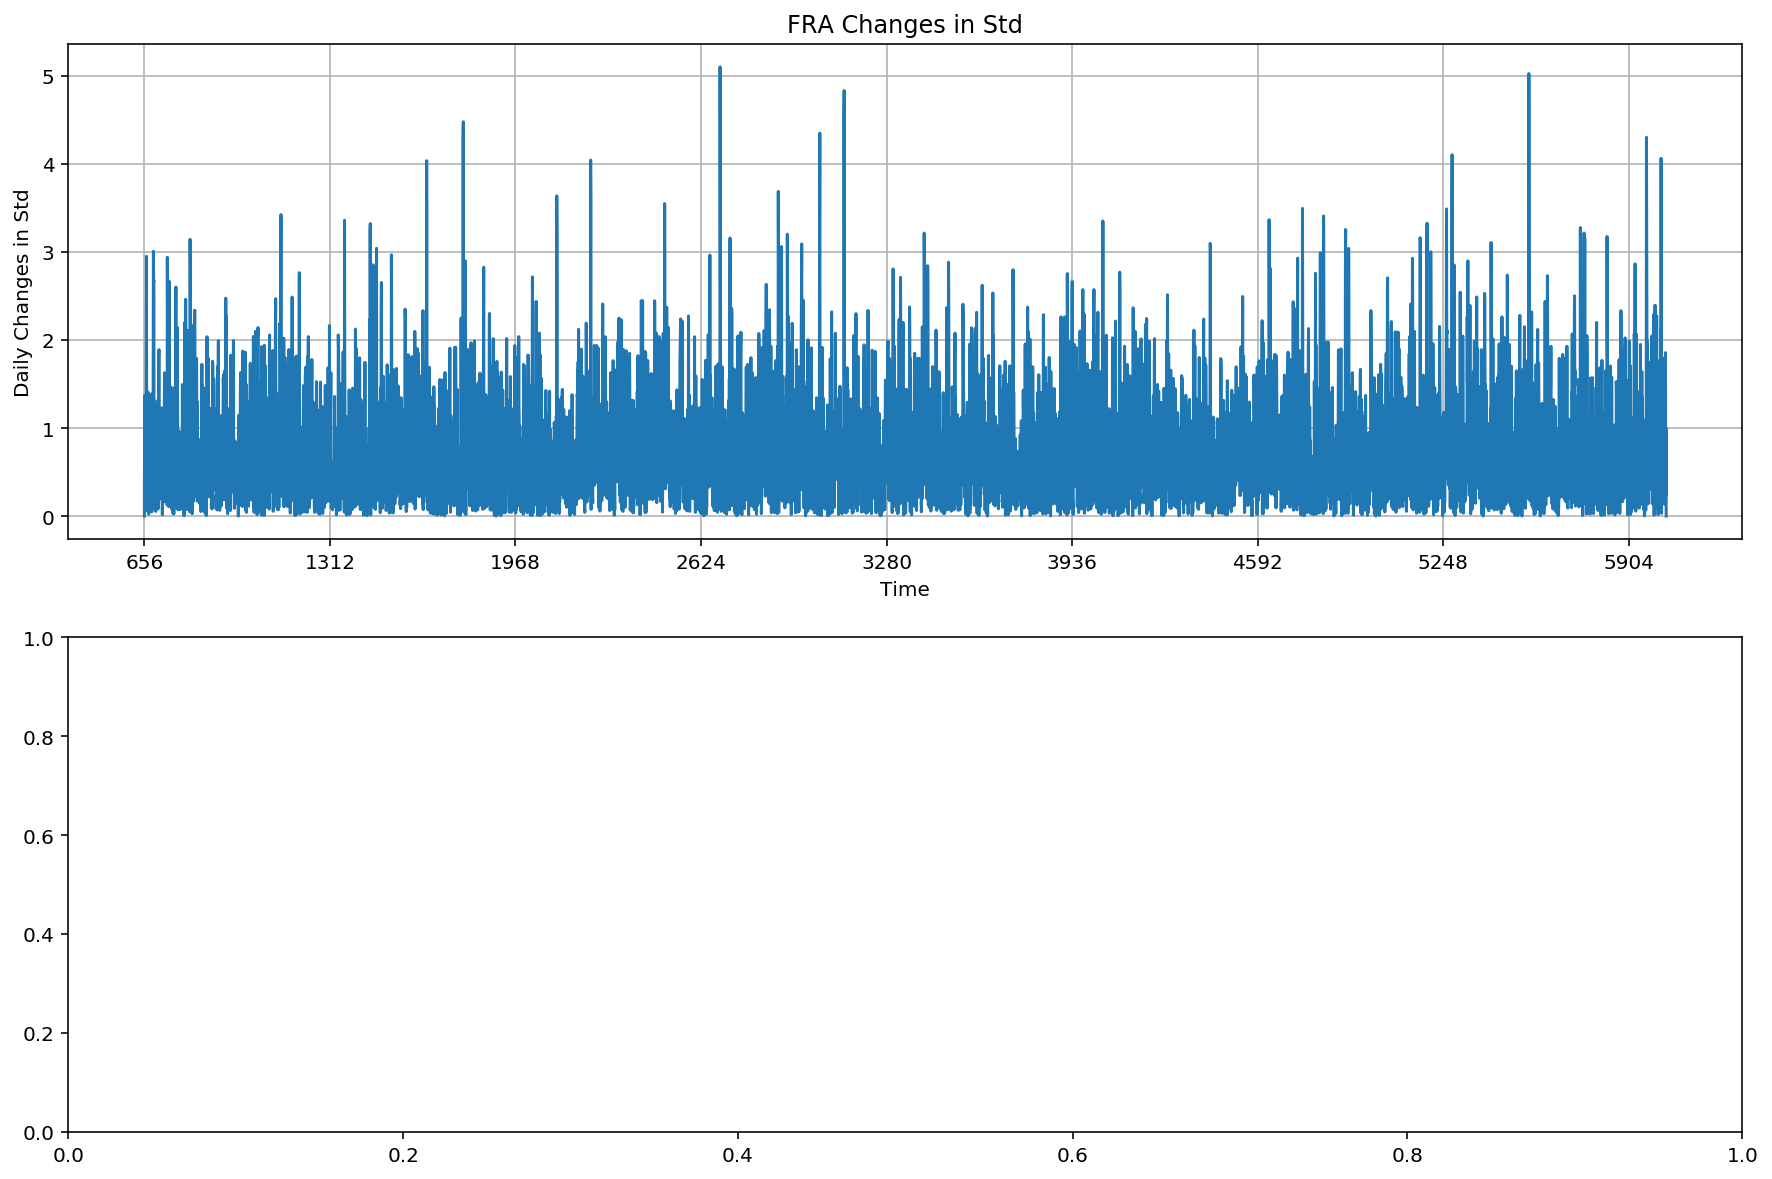

In [162]:
prices = [v[1] for v in list(graph)]
mpl.rcParams['figure.figsize'] = (15,10)
plot_all(prices, range(len(prices)), stock_name='FRA')

# Fractal Brownian Motion

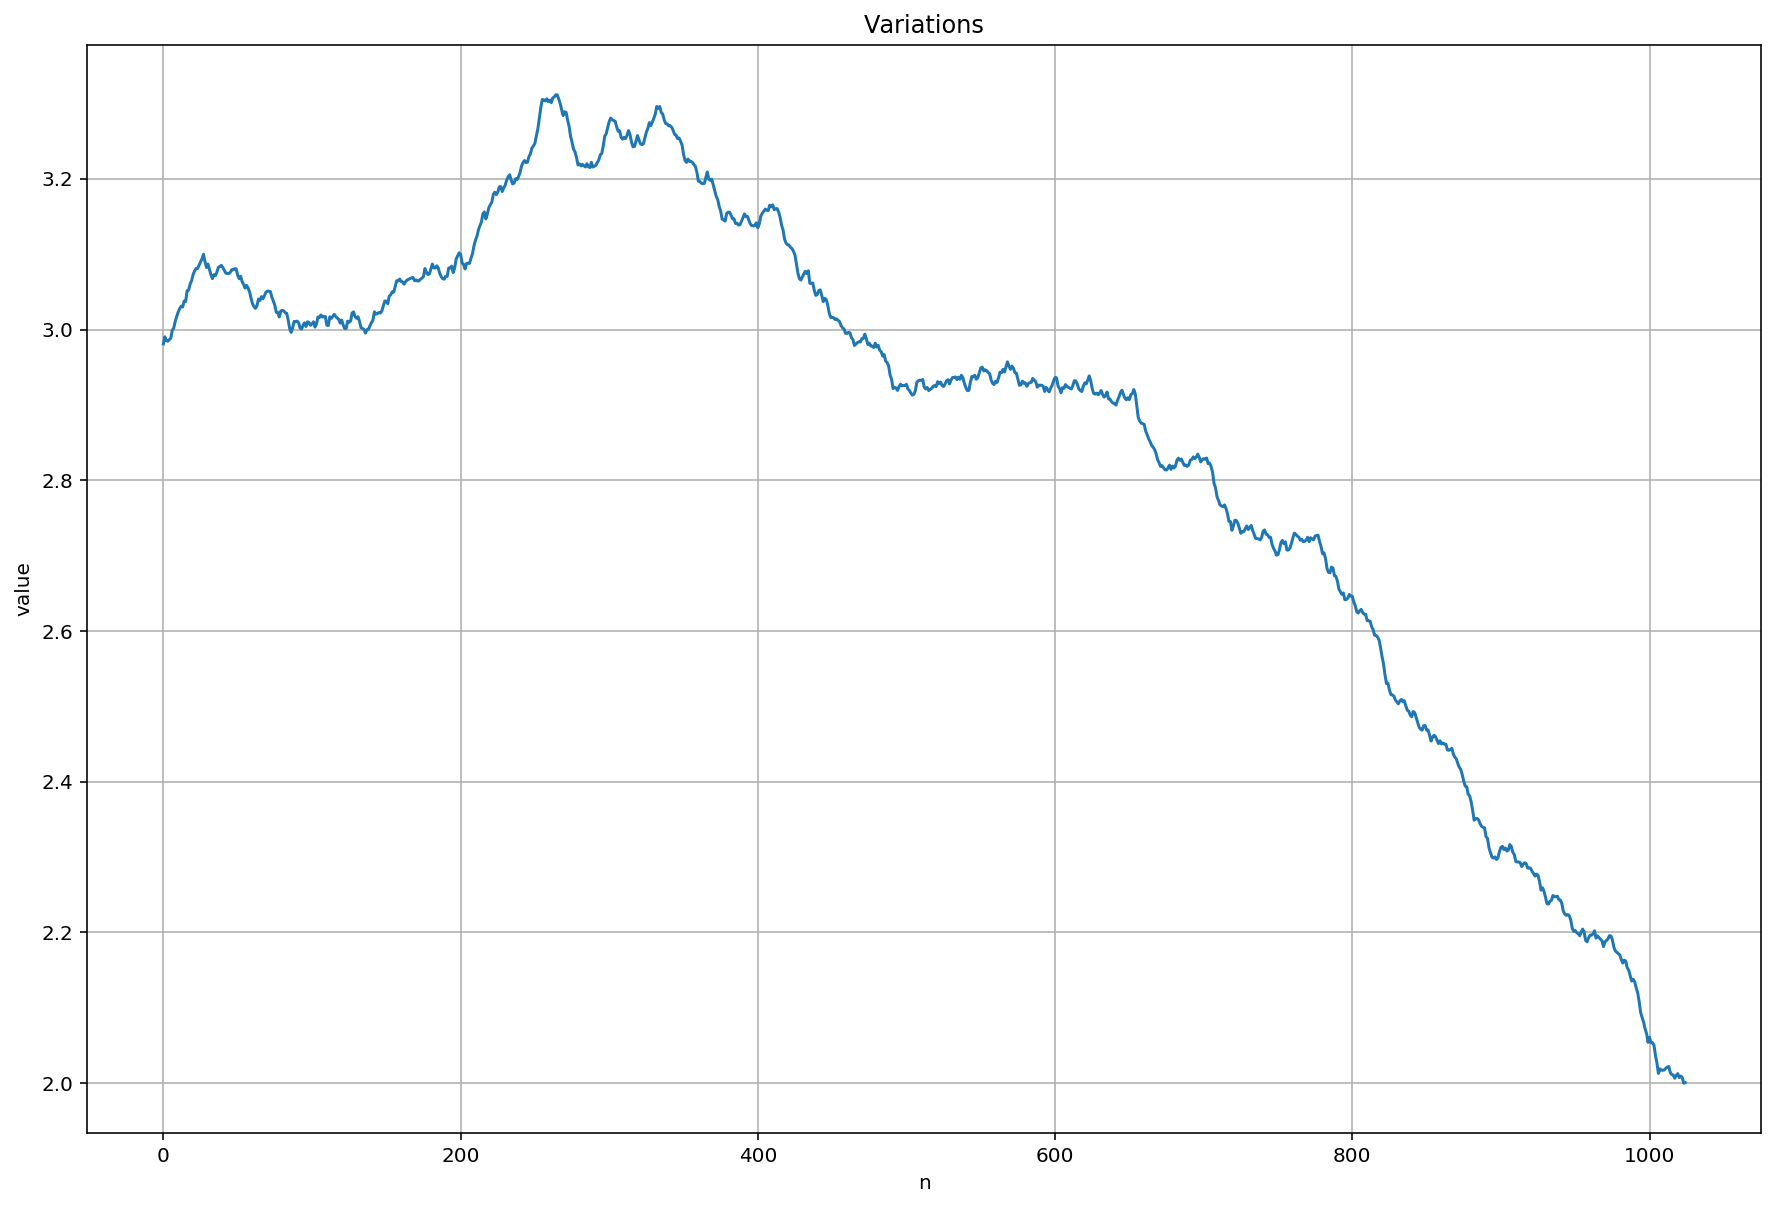

In [163]:
from fbm import FBM
# https://pypi.org/project/fbm/

f = FBM(n=1024, hurst=0.75, length=1, method='daviesharte')

# Generate a fBm realization
fbm_sample = f.fbm()

# Generate a fGn realization
fgn_sample = f.fgn()

# Get the times associated with the fBm
t_values = f.times()

adjusted_fbm_sample = [m+2+abs(min(fbm_sample)) for m in fbm_sample]

plt.plot(range(len(adjusted_fbm_sample)), adjusted_fbm_sample)
plt.xlabel("n")
plt.ylabel("value")
plt.title("Variations")
plt.grid()
mpl.rcParams['figure.figsize'] = (10,3)

ValueError: math domain error

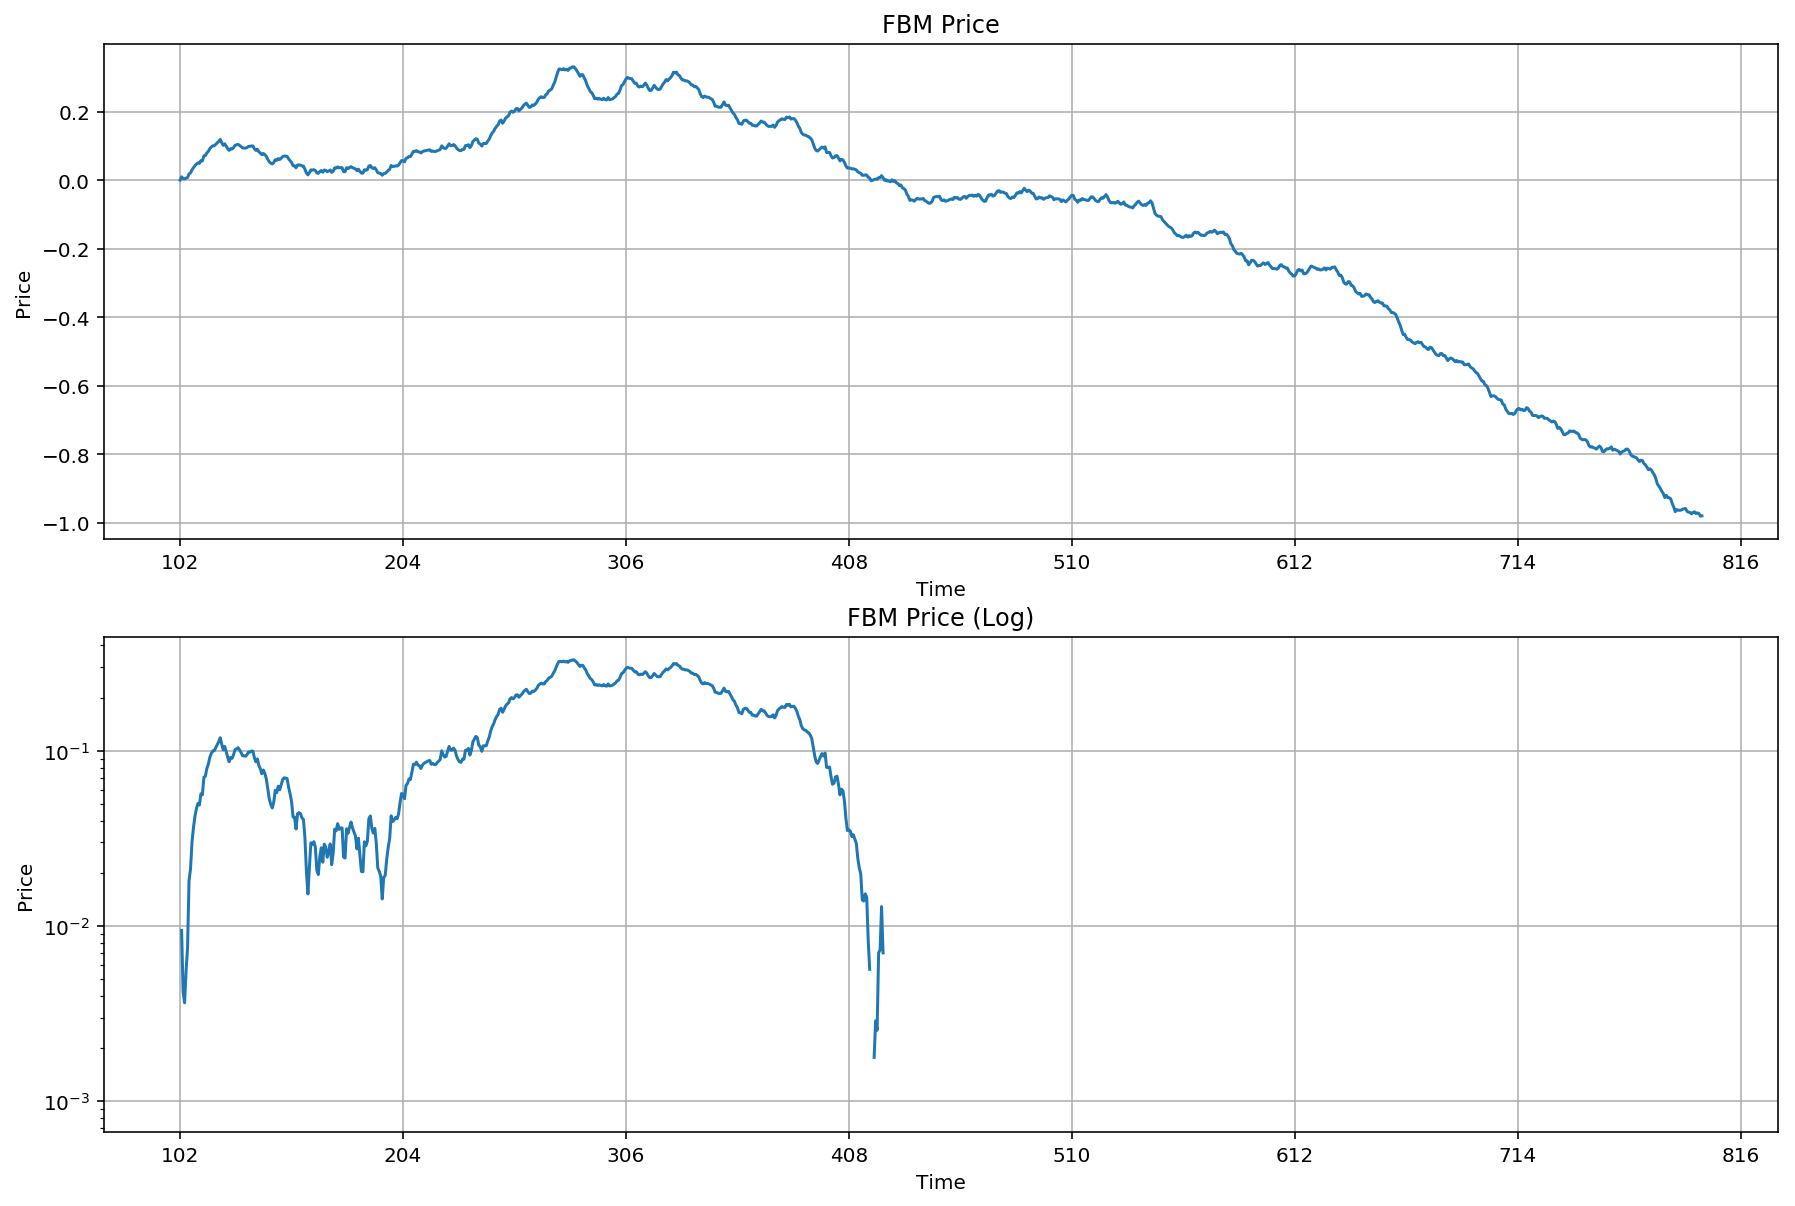

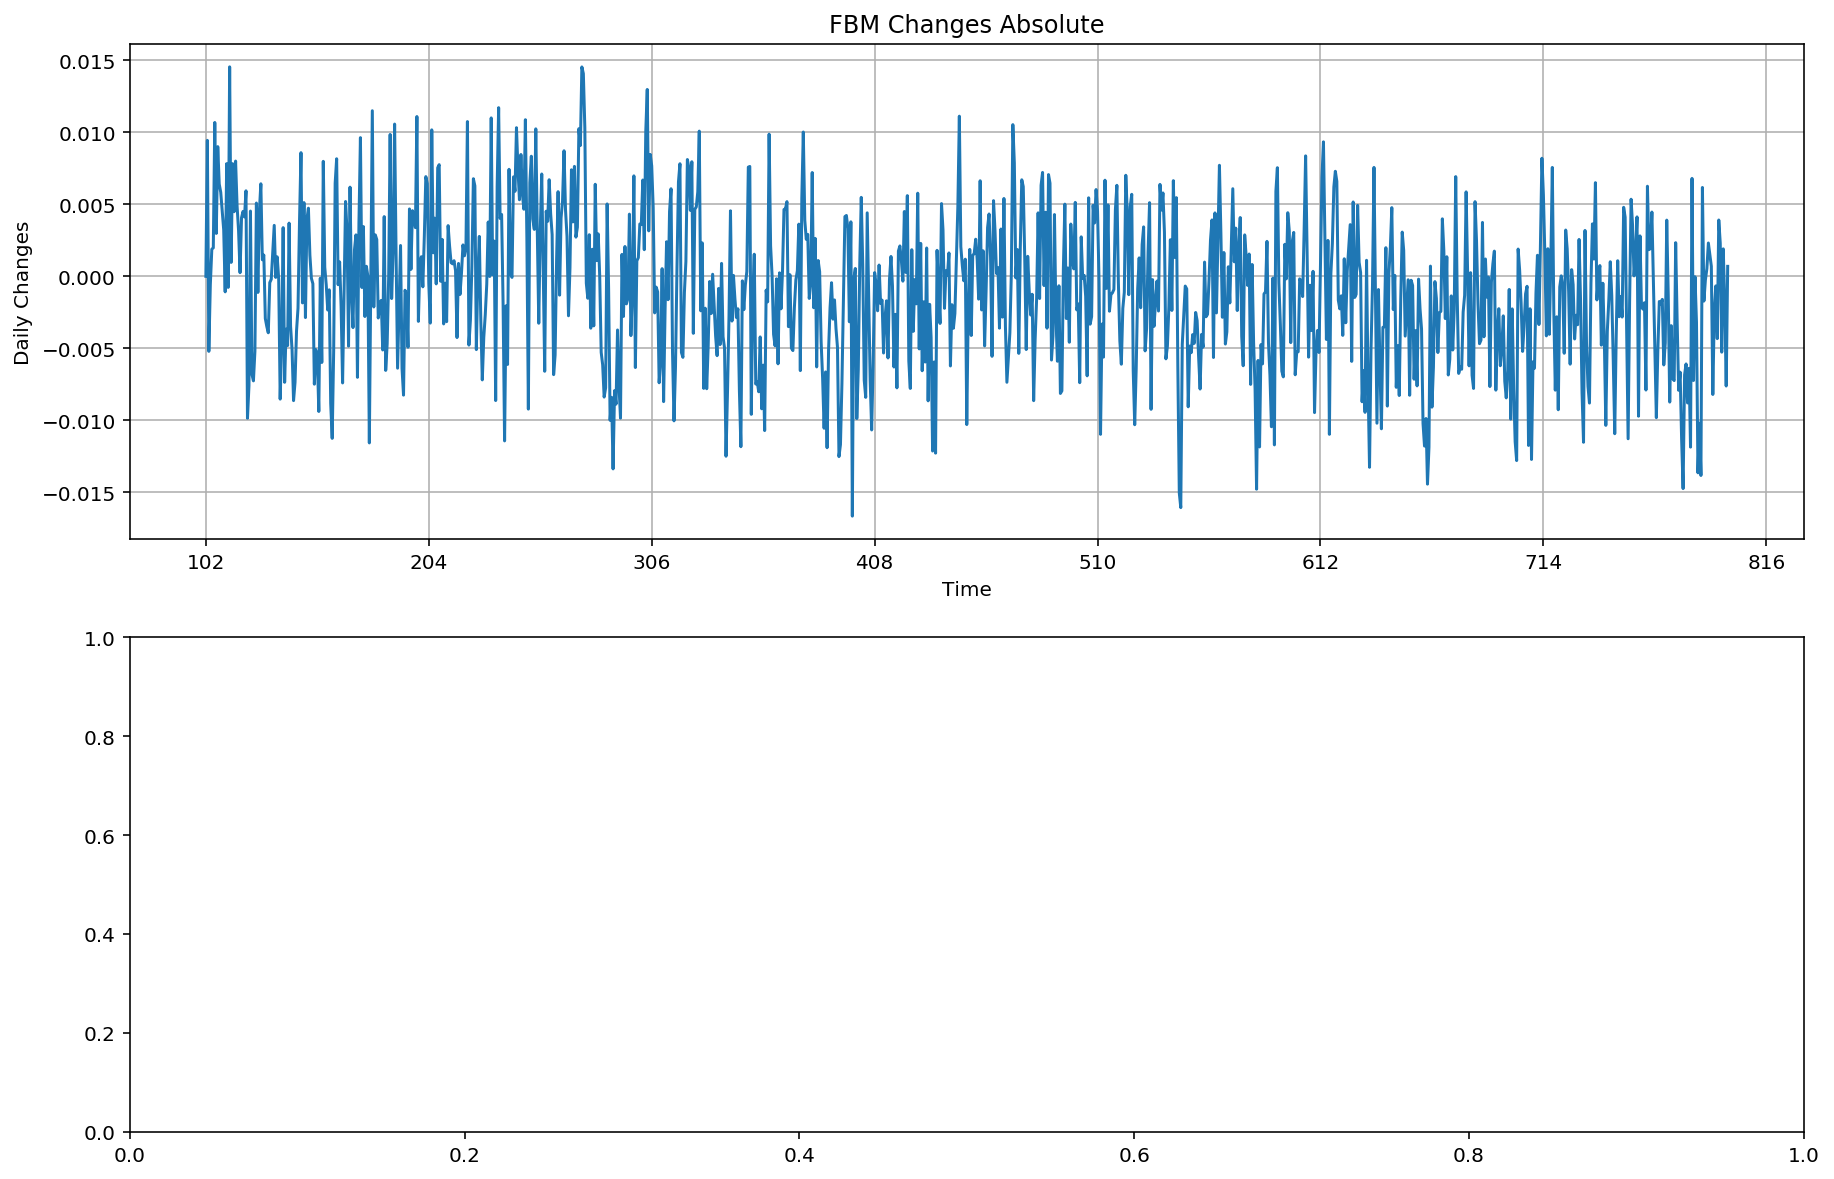

In [164]:
plot_all(fbm_sample, range(len(adjusted_fbm_sample)), stock_name='FBM')

In [ ]:
from fbm import MBM


# Example Hurst function with respect to time.
def h(t):
    return 0.25 * math.sin(20*t) + 0.5

m = MBM(n=1024, hurst=h, length=1, method='riemannliouville')

# Generate a mBm realization
mbm_sample = m.mbm()

# Generate a mGn realization
mgn_sample = m.mgn()

# Get the times associated with the mBm
t_values = m.times()
adjusted_mbm_sample = [m+2+abs(min(mbm_sample)) for m in mbm_sample]

plt.plot(range(len(adjusted_mbm_sample)), adjusted_mbm_sample)
plt.xlabel("n")
plt.ylabel("value")
plt.title("Variations")
plt.grid()
mpl.rcParams['figure.figsize'] = (10,3)

In [ ]:
plot_all(mbm_sample, range(len(adjusted_mbm_sample)), stock_name='MBM')